# Deep Learning Charity Success

In [61]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os
from tensorflow.keras.callbacks import ModelCheckpoint


### Load/Evaluate charity data

In [62]:
#  Import and read the charity_data.csv.
application_df = pd.read_csv("Resources/charity_data.csv")
application_df

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...,...,...
34294,996009318,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,996010315,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,996012607,PTA HAWAII CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,996015768,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


the 'EIN' and 'NAME' columns contain unnecessary data for model training

In [63]:
# Determine the number of unique values in each column.
application_df.nunique()

EIN                       34299
NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
STATUS                        2
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [64]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=["EIN", "NAME"])

'Application_type" and "Classification" could be binned to reduce model confusion.
"ask_amt" will not be binned as its values will be a useful factor after standardization

In [65]:
# Look at APPLICATION_TYPE value counts for binning
application_type_count = application_df.APPLICATION_TYPE.value_counts()
application_type_count

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [66]:
# Look at the Classification value counts for binning
classification_count = application_df.CLASSIFICATION.value_counts()
classification_count.head(50)

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
C2800       95
C7100       75
C1300       58
C1280       50
C1230       36
C1400       34
C7200       32
C2300       32
C1240       30
C8000       20
C7120       18
C1500       16
C1800       15
C6000       15
C1250       14
C8200       11
C1238       10
C1278       10
C1235        9
C1237        9
C7210        7
C2400        6
C1720        6
C4100        6
C1257        5
C1600        5
C1260        3
C2710        3
C0           3
C3200        2
C1234        2
C1246        2
C1267        2
C1256        2
C2190        1
C4200        1
C2600        1
C5200        1
C1370        1
Name: CLASSIFICATION, dtype: int64

T3 Application types, and C1000 classification types, heavily outnumber the other features. This may cause unwanted model performance later

<Axes: ylabel='Density'>

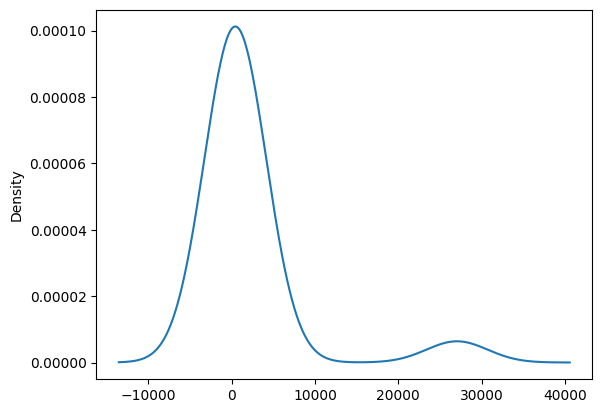

In [67]:
# Visualize the density of the APPLICATION_TYPE column
application_type_count.plot.density()


Looking to find which value to best bin the APPLICATION_TYPE column, the plot "falls off" at an approximate count of 5-6000. As predicted the skewed quantity of T3 loans is showing signs of negatively influencing the model. If we were to bin our types at this level we would only have 3 buckets.

<Axes: ylabel='Density'>

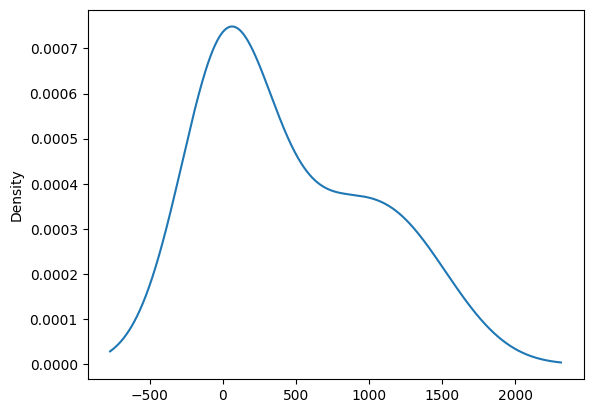

In [68]:
# Vizualize the density without the T3 type

reduced_application_type_count = application_type_count[~(application_type_count.index=='T3')]

reduced_application_type_count.plot.density()

By removing the T3 loans we can see a better binning value would be at 1000.

<Axes: ylabel='Density'>

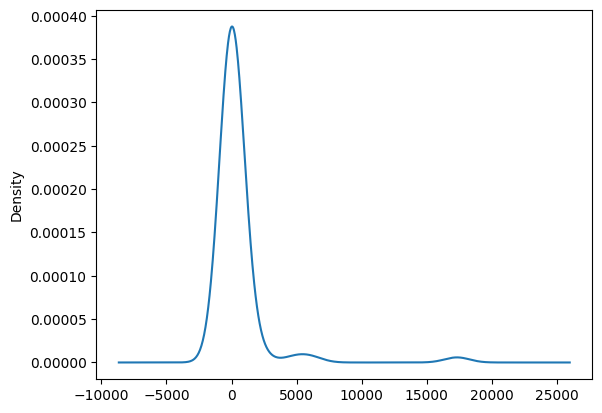

In [69]:
# Visualize the density of the CLASSIFICATION column
classification_count.plot.density()

The density of the Classification column is similar to that of the application_type, this may cause unwanted performance issues.

<Axes: ylabel='Density'>

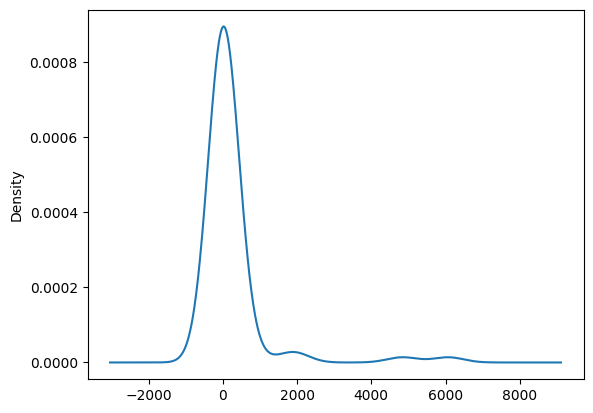

In [70]:
# Visualize the density without the C1000 type

reduced_classification_count = classification_count[~(classification_count.index=='C1000')]
reduced_classification_count.plot.density()

While the change isnt drastic, it does yield a clearer value for binning, at around 500. 

In [71]:
# Bin the APPLICATION_TYPE and CLASSIFICATION columns
replace_application = list(application_type_count[application_type_count < 500].index)
replace_classification = list(classification_count[classification_count < 1000].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")

for class_ in replace_classification:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(class_,"Other")

# confirm binning
application_df.APPLICATION_TYPE.value_counts(), application_df.CLASSIFICATION.value_counts()

(T3       27037
 T4        1542
 T6        1216
 T5        1173
 T19       1065
 T8         737
 T7         725
 T10        528
 Other      276
 Name: APPLICATION_TYPE, dtype: int64,
 C1000    17326
 C2000     6074
 C1200     4837
 Other     2261
 C3000     1918
 C2100     1883
 Name: CLASSIFICATION, dtype: int64)

In [72]:
# Evaluate the data with/without the T3 application type

no_t3 = application_df[~(application_df.APPLICATION_TYPE=='T3')].copy()
t3_only = application_df[application_df.APPLICATION_TYPE=='T3'].copy()

display(len(no_t3),len(t3_only), len(application_df))
display(no_t3.nunique(),t3_only.nunique(), application_df.nunique())

7262

27037

34299

APPLICATION_TYPE             8
AFFILIATION                  6
CLASSIFICATION               5
USE_CASE                     4
ORGANIZATION                 4
STATUS                       1
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       1
ASK_AMT                   1365
IS_SUCCESSFUL                2
dtype: int64

APPLICATION_TYPE             1
AFFILIATION                  6
CLASSIFICATION               6
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   7423
IS_SUCCESSFUL                2
dtype: int64

APPLICATION_TYPE             9
AFFILIATION                  6
CLASSIFICATION               6
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

By comparing the distribution of features between the no_t3 dataframe, and the t3_only dataframe, its apparent that dropping the t3 loan types from our analysis would negatively impact our models training.
The t3_only dataframe is more representative of the original dataset than the no_t3 dataframe is. In order to correct this we will oversample the minority loan types in order to better represent them in our analysis.

In [73]:
# Encode categorical variables using one-hot encoding
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))


# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)

# Merge one-hot encoded features and drop the originals
encoded_application_df = application_df.merge(encode_df,left_index=True,right_index=True).drop(columns=application_cat).copy()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [74]:
# Oversample the data using the SMOTE algorithm
smote = SMOTE(random_state=1, sampling_strategy='minority')


over_x = encoded_application_df.drop(columns=["APPLICATION_TYPE_T3"])
over_y = encoded_application_df["APPLICATION_TYPE_T3"]

# apply SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(over_x, over_y)

# Convert X and y resampled to a DataFrame and concatenate
X_resampled_df = pd.DataFrame(X_resampled, columns=over_x.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['APPLICATION_TYPE_T3'])
enc_smoted_application_df = pd.concat([X_resampled_df,y_resampled_df],axis=1)

# verify the resampled data
enc_smoted_application_df

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,APPLICATION_TYPE_T3
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,108590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,6692,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1,142590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54069,1,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
54070,1,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
54071,1,5000,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
54072,1,5000,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [75]:
# Split our preprocessed data into our features and target arrays

y = enc_smoted_application_df["IS_SUCCESSFUL"]
X = enc_smoted_application_df.drop(columns=["IS_SUCCESSFUL"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=52)

In [76]:
# Scale the data

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Compile, Train, and Evaluate the Model

#### Model 1

In [77]:
# Define the model input, hidden, and output layers
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 30
hidden_nodes_layer2 = 15
hidden_nodes_layer3 = 8


application_nn = tf.keras.models.Sequential()

# First hidden layer
application_nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer1,
        input_dim=number_input_features,
        activation='relu'
    )
)

# Second hidden layer
application_nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer2,
        activation='selu'
    )
)

# Third hidden layer
application_nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer3,
        activation='swish'
    )
)

# Output layer
application_nn.add(tf.keras.layers.Dense(
    units=1, 
    activation="sigmoid"
    )
)
# Check the structure of the model
application_nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 30)                1320      
                                                                 
 dense_13 (Dense)            (None, 15)                465       
                                                                 
 dense_14 (Dense)            (None, 8)                 128       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Define the checkpoint path and filenames
os.makedirs(
    "output/Checkpoints/initialModel_checkpoints/",
    exist_ok=True
    )
checkpoint_path = "output/Checkpoints/initialModel_checkpoints/weights.{epoch:02d}.hdf5"

In [79]:
# Compile the model
application_nn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    )

# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch',
    period=5)

In [80]:
# Train the model
fit_application_nn =\
    application_nn.fit(
        X_train_scaled,
        y_train,
        epochs=25,
        callbacks=[cp_callback]
    )

Epoch 1/25
1268/1268 [==============================] - 12s 9ms/step - loss: 0.5588 - accuracy: 0.7195
Epoch 2/25
1268/1268 [==============================] - 11s 8ms/step - loss: 0.5355 - accuracy: 0.7324
Epoch 3/25
1268/1268 [==============================] - 11s 9ms/step - loss: 0.5316 - accuracy: 0.7361
Epoch 4/25
1268/1268 [==============================] - 11s 9ms/step - loss: 0.5302 - accuracy: 0.7368
Epoch 5/25
1263/1268 [============================>.] - ETA: 0s - loss: 0.5284 - accuracy: 0.7369
Epoch 5: saving model to output/Checkpoints/initialModel_checkpoints/weights.05.hdf5
1268/1268 [==============================] - 11s 9ms/step - loss: 0.5284 - accuracy: 0.7369
Epoch 6/25
1268/1268 [==============================] - 11s 9ms/step - loss: 0.5275 - accuracy: 0.7378
Epoch 7/25
1268/1268 [==============================] - 11s 9ms/step - loss: 0.5265 - accuracy: 0.7396
Epoch 8/25
1268/1268 [==============================] - 11s 9ms/step - loss: 0.5257 - accuracy: 0.7412
Epoc

In [81]:
# Evaluate the model using the test data
model_loss, model_accuracy =\
    application_nn.evaluate(
        X_test_scaled,
        y_test,
        verbose=2,
    )

# get precision recall and f1 scores
y_pred = application_nn.predict(X_test_scaled)
y_pred = np.where(y_pred >= 0.5, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print("Initial Model")
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")


423/423 - 2s - loss: 0.5320 - accuracy: 0.7350 - 2s/epoch - 4ms/step
423/423 [==============================] - 1s 2ms/step
Initial Model
Loss: 0.5320261120796204, Accuracy: 0.7349656224250793
Precision: 0.7253812354613596, Recall: 0.793805685193042, F1: 0.7580525356202309


In [82]:
# Export our model to HDF5 file
tf.keras.models.save_model(
    application_nn,
    "output/Models/initialModel.h5"
    )

#### Model 1 Summary
This model fails to achieve the base target of the analysis, 75% accuracy. This model when ran through several iterations with various node and layer counts was limited to an accuracy score of 74%.

As our data was oversampled to better accommodate one type of loan, and our models performance was lacking, one conclusion that can be drawn is that the "T3" "APPLICATION_TYPE" data was overfitting our initial model.

#### Models 2/3

The errors in the last model may have been influenced by the application type, these models train independently around that feature and test results on its counterpart dataset.

In [83]:
# Relaod the data
application_df2 = pd.read_csv(
    "Resources/charity_data.csv"
    )

# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df2 = application_df2.drop(
    columns=["EIN","NAME"]
    )

In [84]:
# Gather at APPLICATION_TYPE and CLASSIFICATION value counts for binning
application_type_count = application_df2.APPLICATION_TYPE.value_counts()
classification_count = application_df2.CLASSIFICATION.value_counts()

# Bin the APPLICATION_TYPE and CLASSIFICATION columns
replace_application = list(application_type_count[application_type_count < 500].index)
replace_classification = list(classification_count[classification_count < 1000].index)

# Replace in dataframe
for app in replace_application:
    application_df2.APPLICATION_TYPE = application_df2.APPLICATION_TYPE.replace(app,"Other")

for class_ in replace_classification:
    application_df2.CLASSIFICATION = application_df2.CLASSIFICATION.replace(class_,"Other")

# confirm binning
application_df2.APPLICATION_TYPE.value_counts(), application_df2.CLASSIFICATION.value_counts()

(T3       27037
 T4        1542
 T6        1216
 T5        1173
 T19       1065
 T8         737
 T7         725
 T10        528
 Other      276
 Name: APPLICATION_TYPE, dtype: int64,
 C1000    17326
 C2000     6074
 C1200     4837
 Other     2261
 C3000     1918
 C2100     1883
 Name: CLASSIFICATION, dtype: int64)

In [85]:
# Encode application_df2

# Encode categorical variables using one-hot encoding
application_cat2 = application_df2.dtypes[application_df2.dtypes == "object"].index.tolist()
# Create a OneHotEncoder instance
enc2 = OneHotEncoder(sparse=False)
# Fit and transform the OneHotEncoder using the categorical variable list
encode_df2 = pd.DataFrame(enc2.fit_transform(application_df2[application_cat2]))
# Add the encoded variable names to the dataframe
encode_df2.columns = enc2.get_feature_names_out(application_cat2)
# Merge one-hot encoded features and drop the originals
encoded_application_df2 = application_df2.merge(encode_df2,left_index=True,right_index=True).drop(columns=application_cat2).copy()

# split the data by t3 and no_t3
encoded_no_t3 = encoded_application_df2[~(encoded_application_df2.APPLICATION_TYPE_T3==1)].copy()
encoded_t3_only = encoded_application_df2[encoded_application_df2.APPLICATION_TYPE_T3==1].copy()

# Split data into training and testing datasets
y_no_t3 = encoded_no_t3["IS_SUCCESSFUL"]
X_no_t3 = encoded_no_t3.drop(columns=["IS_SUCCESSFUL"])
y_t3_only = encoded_t3_only["IS_SUCCESSFUL"]
X_t3_only = encoded_t3_only.drop(columns=["IS_SUCCESSFUL"])

# split the data into training and testing sets
X_train_no_t3, X_test_no_t3, y_train_no_t3, y_test_no_t3 = train_test_split(X_no_t3, y_no_t3, random_state=52)
X_train_t3_only, X_test_t3_only, y_train_t3_only, y_test_t3_only = train_test_split(X_t3_only, y_t3_only, random_state=52)


# Scale the data
scaler_no_t3 = StandardScaler()
scaler_t3_only = StandardScaler()
X_scaler_no_t3 = scaler_no_t3.fit(X_train_no_t3)
X_scaler_t3_only = scaler_t3_only.fit(X_train_t3_only)

X_train_no_t3_scaled = X_scaler_no_t3.transform(X_train_no_t3)
X_test_no_t3_scaled = X_scaler_no_t3.transform(X_test_no_t3)
X_train_t3_only_scaled = X_scaler_t3_only.transform(X_train_t3_only)
X_test_t3_only_scaled = X_scaler_t3_only.transform(X_test_t3_only)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [86]:
# create the t3_only model

# Define the model input, hidden, and output layers
number_input_features = len(X_train_t3_only_scaled[0])
hidden_nodes_layer1 = 30
hidden_nodes_layer2 = 15

t3_only_nn = tf.keras.models.Sequential()

# First hidden layer
t3_only_nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer1,
        input_dim=number_input_features,
        activation='relu'
    ))
# Second hidden layer
t3_only_nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer2,
        activation='relu'
    ))
# Output layer
t3_only_nn.add(tf.keras.layers.Dense(
    units=1, 
    activation="sigmoid"
    ))

# Check the structure of the model
t3_only_nn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 30)                1320      
                                                                 
 dense_17 (Dense)            (None, 15)                465       
                                                                 
 dense_18 (Dense)            (None, 1)                 16        
                                                                 
Total params: 1,801
Trainable params: 1,801
Non-trainable params: 0
_________________________________________________________________


In [87]:
# create the no_t3 model

# Define the model input, hidden, and output layers
number_input_features = len(X_train_no_t3_scaled[0])
hidden_nodes_layer1 = 30
hidden_nodes_layer2 = 15

no_t3_nn = tf.keras.models.Sequential()

# First hidden layer
no_t3_nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer1,
        input_dim=number_input_features,
        activation='relu'
    ))
# Second hidden layer
no_t3_nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer2,
        activation='relu'
    ))
# Output layer
no_t3_nn.add(tf.keras.layers.Dense(
    units=1, 
    activation="sigmoid"
    ))

# Check the structure of the model
no_t3_nn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 30)                1320      
                                                                 
 dense_20 (Dense)            (None, 15)                465       
                                                                 
 dense_21 (Dense)            (None, 1)                 16        
                                                                 
Total params: 1,801
Trainable params: 1,801
Non-trainable params: 0
_________________________________________________________________


In [88]:
# Define the checkpoint path and filenames
os.makedirs(
    "output/Checkpoints/no_t3_checkpoints/",
    exist_ok=True
    )
os.makedirs(
    "output/Checkpoints/t3_only_checkpoints/",
    exist_ok=True
    )
checkpoint_path_t3_only = "output/Checkpoints/t3_only_checkpoints/weights.{epoch:02d}.hdf5"
checkpoint_path_no_t3 = "output/Checkpoints/no_t3_checkpoints/weights.{epoch:02d}.hdf5"

In [89]:
# Compile the model
no_t3_nn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    )

# Create a callback that saves the model's weights every epoch
cp_callback_no_t3 = ModelCheckpoint(
    filepath=checkpoint_path_no_t3, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_no_t3_nn =\
    no_t3_nn.fit(
        X_train_no_t3_scaled,
        y_train_no_t3,
        epochs=25,
        callbacks=[cp_callback_no_t3]
    )

Epoch 1/25
171/171 [==============================] - 2s 7ms/step - loss: 0.6021 - accuracy: 0.6992
Epoch 2/25
171/171 [==============================] - 1s 6ms/step - loss: 0.5240 - accuracy: 0.7505
Epoch 3/25
171/171 [==============================] - 1s 6ms/step - loss: 0.5095 - accuracy: 0.7510
Epoch 4/25
171/171 [==============================] - 1s 7ms/step - loss: 0.5024 - accuracy: 0.7584
Epoch 5/25
165/171 [===========================>..] - ETA: 0s - loss: 0.4989 - accuracy: 0.7604
Epoch 5: saving model to output/Checkpoints/no_t3_checkpoints/weights.05.hdf5
171/171 [==============================] - 1s 7ms/step - loss: 0.5001 - accuracy: 0.7589
Epoch 6/25
171/171 [==============================] - 1s 6ms/step - loss: 0.4973 - accuracy: 0.7600
Epoch 7/25
171/171 [==============================] - 1s 7ms/step - loss: 0.4953 - accuracy: 0.7633
Epoch 8/25
171/171 [==============================] - 1s 6ms/step - loss: 0.4936 - accuracy: 0.7607
Epoch 9/25
171/171 [=================

In [90]:
# Compile the model
t3_only_nn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    )

# Create a callback that saves the model's weights every epoch
cp_callback_t3_only = ModelCheckpoint(
    filepath=checkpoint_path_t3_only, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_t3_only_nn =\
    t3_only_nn.fit(
        X_train_t3_only_scaled,
        y_train_t3_only,
        epochs=25,
        callbacks=[cp_callback_t3_only]
    )

Epoch 1/25
634/634 [==============================] - 4s 6ms/step - loss: 0.5927 - accuracy: 0.7048
Epoch 2/25
634/634 [==============================] - 4s 6ms/step - loss: 0.5696 - accuracy: 0.7206
Epoch 3/25
634/634 [==============================] - 4s 6ms/step - loss: 0.5669 - accuracy: 0.7220
Epoch 4/25
634/634 [==============================] - 4s 6ms/step - loss: 0.5662 - accuracy: 0.7215
Epoch 5/25
633/634 [============================>.] - ETA: 0s - loss: 0.5649 - accuracy: 0.7245
Epoch 5: saving model to output/Checkpoints/t3_only_checkpoints/weights.05.hdf5
634/634 [==============================] - 4s 6ms/step - loss: 0.5650 - accuracy: 0.7243
Epoch 6/25
634/634 [==============================] - 4s 6ms/step - loss: 0.5642 - accuracy: 0.7240
Epoch 7/25
634/634 [==============================] - 4s 6ms/step - loss: 0.5635 - accuracy: 0.7244
Epoch 8/25
634/634 [==============================] - 4s 6ms/step - loss: 0.5634 - accuracy: 0.7244
Epoch 9/25
634/634 [===============

In [91]:
# Evaluate the model using the test data
model_loss_no_t3, model_accuracy_no_t3 =\
    no_t3_nn.evaluate(
        X_test_no_t3_scaled,
        y_test_no_t3,
        verbose=2,
    )
model_loss_t3_only, model_accuracy_t3_only =\
    t3_only_nn.evaluate(
        X_test_t3_only_scaled,
        y_test_t3_only,
        verbose=2,
    )

# make predictions on the opposite models test data
predictions_no_t3 = no_t3_nn.predict(X_test_t3_only_scaled)
predictions_t3_only = t3_only_nn.predict(X_test_no_t3_scaled)
predictions_no_t3 = np.where(predictions_no_t3 >= 0.5, 1, 0)
predictions_t3_only = np.where(predictions_t3_only >= 0.5, 1, 0)

# get the precision, recall, f1-score, and support for both models

# no_t3 model
precision_no_t3 = precision_score(y_test_t3_only, predictions_no_t3)
recall_no_t3 = recall_score(y_test_t3_only, predictions_no_t3)
f1_no_t3 = f1_score(y_test_t3_only, predictions_no_t3)

# t3_only model
precision_t3_only = precision_score(y_test_no_t3,predictions_t3_only)
recall_t3_only = recall_score(y_test_no_t3, predictions_t3_only)
f1_t3_only = f1_score(y_test_no_t3, predictions_t3_only)

print('\n')
print("NO_T3 MODEL")
print(f"Loss: {model_loss_no_t3}, Accuracy: {model_accuracy_no_t3}")
print(f"Precision: {precision_no_t3}, Recall: {recall_no_t3}, F1-Score: {f1_no_t3}")
print('\n')
print("T3_ONLY MODEL")
print(f"Loss: {model_loss_t3_only}, Accuracy: {model_accuracy_t3_only}")
print(f"Precision: {precision_t3_only}, Recall: {recall_t3_only}, F1-Score: {f1_t3_only}")

57/57 - 0s - loss: 0.4615 - accuracy: 0.7792 - 335ms/epoch - 6ms/step
212/212 - 1s - loss: 0.5685 - accuracy: 0.7206 - 800ms/epoch - 4ms/step
57/57 [==============================] - 0s 2ms/step
NO_T3 MODEL
Loss: 0.461511492729187, Accuracy: 0.7791849970817566
Precision: 0.5991514480723114, Recall: 0.8947658402203856, F1-Score: 0.7177107501933488
T3_ONLY MODEL
Loss: 0.5684725046157837, Accuracy: 0.7205621004104614
Precision: 0.6496551724137931, Recall: 0.4931937172774869, F1-Score: 0.5607142857142857


In [92]:
# Export our model to HDF5 file
tf.keras.models.save_model(
    no_t3_nn,
    "output/Models/no_t3.h5"
    )
tf.keras.models.save_model(
    t3_only_nn,
    "output/Models/t3_only.h5"
    )

#### Model 2/3 Summary

Unfortunately even separating the data by the overpopulated application_type didnt provide a successful outcome.
The model trained on the no_t3 data performed better overall which came as a surprise as the t3_only dataset, while being limited in that one feature, was a better representation of the dataset as a whole. 

#### Model 4

In [99]:
# reload the data

application_df3 = pd.read_csv(
    "Resources/charity_data.csv")

# drop the EIN and NAME columns
application_df3 = application_df3.drop(
    columns=["EIN", "NAME"])

In [100]:
# Gather at APPLICATION_TYPE and CLASSIFICATION value counts for binning
application_type_count3 = application_df3.APPLICATION_TYPE.value_counts()
classification_count3 = application_df3.CLASSIFICATION.value_counts()

# Bin the APPLICATION_TYPE and CLASSIFICATION columns
replace_application3 = list(application_type_count3[application_type_count3 < 500].index)
replace_classification3 = list(classification_count3[classification_count3 < 1000].index)

# Replace in dataframe
for app in replace_application3:
    application_df3.APPLICATION_TYPE = application_df3.APPLICATION_TYPE.replace(app,"Other")

for class_ in replace_classification3:
    application_df3.CLASSIFICATION = application_df3.CLASSIFICATION.replace(class_,"Other")

# confirm binning
application_df3.APPLICATION_TYPE.value_counts(), application_df3.CLASSIFICATION.value_counts()

(T3       27037
 T4        1542
 T6        1216
 T5        1173
 T19       1065
 T8         737
 T7         725
 T10        528
 Other      276
 Name: APPLICATION_TYPE, dtype: int64,
 C1000    17326
 C2000     6074
 C1200     4837
 Other     2261
 C3000     1918
 C2100     1883
 Name: CLASSIFICATION, dtype: int64)

In [101]:
# Encode categorical variables using one-hot encoding
application_cat = application_df3.dtypes[application_df3.dtypes == "object"].index.tolist()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df3[application_cat]))


# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)

# Merge one-hot encoded features and drop the originals
encoded_application_df3 = application_df3.merge(encode_df,left_index=True,right_index=True).drop(columns=application_cat).copy()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [102]:
from imblearn.under_sampling import ClusterCentroids

# undersample the data
under_x = encoded_application_df3.drop(columns=["APPLICATION_TYPE_T3"])
under_y = encoded_application_df3["APPLICATION_TYPE_T3"]

# apply the cc method
cc = ClusterCentroids(random_state=1)
under_x_resampled, under_y_resampled = cc.fit_resample(under_x, under_y)

# Convert X and y resampled to a DataFrame and concatenate
X_resampled_df = pd.DataFrame(under_x_resampled, columns=under_x.columns)
y_resampled_df = pd.DataFrame(under_y_resampled, columns=['APPLICATION_TYPE_T3'])
enc_cc_application_df = pd.concat([X_resampled_df,y_resampled_df],axis=1)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [105]:
# Split our preprocessed data into our features and target arrays

y = enc_cc_application_df["IS_SUCCESSFUL"]
X = enc_cc_application_df.drop(columns=["IS_SUCCESSFUL"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=52)

# Scale the data

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [106]:
# Define the model input, hidden, and output layers
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 30
hidden_nodes_layer2 = 15
hidden_nodes_layer3 = 8


under_nn = tf.keras.models.Sequential()

# First hidden layer
under_nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer1,
        input_dim=number_input_features,
        activation='relu'
    )
)

# Second hidden layer
under_nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer2,
        activation='selu'
    )
)

# Third hidden layer
under_nn.add(
    tf.keras.layers.Dense(
        units=hidden_nodes_layer3,
        activation='swish'
    )
)

# Output layer
under_nn.add(tf.keras.layers.Dense(
    units=1, 
    activation="sigmoid"
    )
)
# Check the structure of the model
under_nn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 30)                1320      
                                                                 
 dense_23 (Dense)            (None, 15)                465       
                                                                 
 dense_24 (Dense)            (None, 8)                 128       
                                                                 
 dense_25 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,922
Trainable params: 1,922
Non-trainable params: 0
_________________________________________________________________


In [107]:
# Define the checkpoint path and filenames
os.makedirs(
    "output/Checkpoints/undersampleModel_checkpoints/",
    exist_ok=True
    )
checkpoint_path_under = "output/Checkpoints/undersampleModel/weights.{epoch:02d}.hdf5"

In [108]:
# Compile the model
under_nn.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
    )

# Create a callback that saves the model's weights every epoch
cp_callback_under = ModelCheckpoint(
    filepath=checkpoint_path_under, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch',
    period=5)

In [109]:
# Train the model
fit_under_nn =\
    under_nn.fit(
        X_train_scaled,
        y_train,
        epochs=25,
        callbacks=[cp_callback_under]
    )

Epoch 1/25
341/341 [==============================] - 5s 13ms/step - loss: 0.5955 - accuracy: 0.6892
Epoch 2/25
341/341 [==============================] - 3s 9ms/step - loss: 0.5635 - accuracy: 0.7113
Epoch 3/25
341/341 [==============================] - 3s 9ms/step - loss: 0.5559 - accuracy: 0.7142
Epoch 4/25
341/341 [==============================] - 4s 10ms/step - loss: 0.5520 - accuracy: 0.7164
Epoch 5/25
341/341 [==============================] - ETA: 0s - loss: 0.5501 - accuracy: 0.7172
Epoch 5: saving model to output/Checkpoints/undersampleModel/weights.05.hdf5
341/341 [==============================] - 4s 11ms/step - loss: 0.5501 - accuracy: 0.7172
Epoch 6/25
341/341 [==============================] - 3s 9ms/step - loss: 0.5471 - accuracy: 0.7183
Epoch 7/25
341/341 [==============================] - 3s 10ms/step - loss: 0.5463 - accuracy: 0.7178
Epoch 8/25
341/341 [==============================] - 3s 9ms/step - loss: 0.5450 - accuracy: 0.7197
Epoch 9/25
341/341 [==============

In [110]:
# Evaluate the model using the test data
model_loss, model_accuracy =\
    under_nn.evaluate(
        X_test_scaled,
        y_test,
        verbose=2,
    )

# get precision recall and f1 scores
y_pred = under_nn.predict(X_test_scaled)
y_pred = np.where(y_pred >= 0.5, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


print("Initial Model")
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
print(f"Precision: {precision}, Recall: {recall}, F1: {f1}")

114/114 - 1s - loss: 0.5596 - accuracy: 0.7108 - 620ms/epoch - 5ms/step
114/114 [==============================] - 0s 3ms/step
Initial Model
Loss: 0.5596217513084412, Accuracy: 0.7108234763145447
Precision: 0.6721574929690639, Recall: 0.8772941793392763, F1: 0.7611464968152867


#### Model 4 Summary

Undersmapling the T3 application_type didnt seem to have the desired effect either. It seems training the data without the T3 values was best preparing the model for predicting charity outcome success. 